In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cirq.contrib.svg import SVGCircuit, circuit_to_svg
from contextlib import contextmanager
from pathlib import Path
from typing import Any, Callable, Generator, Iterable
import cirq
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from eqmarl import *

In [21]:
d_qubits = 2
n_agents = 2
n_layers = 1
repetitions = 1000
nrows, ncols = 3, 3

## Various input states

### Eigenvectors of the policy unitary

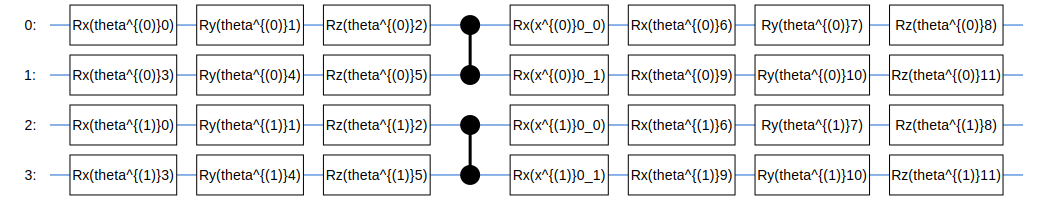

In [13]:
# Create parameterized circuit.
circuit, symbols = build_parameterized_system_circuit(
    d=d_qubits,
    n=n_agents,
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=1, symbol_superscript_index=aidx),
    initial_state_prep_fn=None,
    meas_flag=False, # Do not measure.
)
SVGCircuit(circuit)

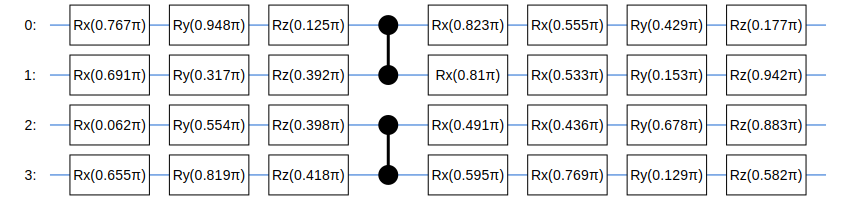

In [4]:
# Resolve symbols to concrete values.
symbol_resolver_fn = ParamResolverRandomThetaRandomS()
circuit_resolved = cirq.resolve_parameters(circuit, param_resolver=cirq.ParamResolver(symbol_resolver_fn(symbols)))
SVGCircuit(circuit_resolved)

In [5]:
U = cirq.unitary(circuit_resolved)
U.shape

(16, 16)

In [6]:
eig_vals, eig_vects = cirq.unitary_eig(U) # eig_vects is a matrix with eigenvectors as columns.
eig_vects[:,0]

array([ 0.15924756+0.25102037j,  0.29779287+0.22646434j,
        0.16609413+0.15433396j,  0.01866583-0.36411543j,
        0.09726676+0.0628207j ,  0.14226859+0.03154017j,
        0.08392054+0.02750403j, -0.05277887-0.13183973j,
       -0.08899664+0.03352794j, -0.09032985+0.07852208j,
       -0.05915889+0.04197035j,  0.11283092+0.02956415j,
        0.13258971-0.29281466j,  0.02825197-0.40354212j,
        0.0410987 -0.24168856j, -0.3403302 +0.19897463j])

In [7]:
# Superposition of first and last eigenvector.
psi = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]
psi.shape

(16,)

#### Run test using initial state as superposition of eigenvectors.

First, we define a variational + encoding policy circuit, resolve a random set of parameters to the symbols, and then compute the eigenvectors of the combined system unitary (considering all agents).

In [17]:
# Create parameterized circuit.
circuit_policies, symbols = build_parameterized_system_circuit(
    d=d_qubits,
    n=n_agents,
    policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
    initial_state_prep_fn=None,
    meas_flag=False, # Do not measure.
)

# Extract unitary from resolved circuit.
symbol_resolver_fn = ParamResolverRandomThetaRandomS()
U, circuit_policies_resolved = extract_unitary_from_parameterized_circuit(circuit_policies, symbols, symbol_resolver_fn, return_circuit=True)

# Extract eigenvectors of the unitary.
eig_vals, eig_vects = cirq.unitary_eig(U) # eig_vects is a matrix with eigenvectors as columns.

##### Equal superposition of first and last eigenvector

initial_state_vector=(0.01+0.02j)|0000⟩ + 0.02j|0001⟩ + 0.01j|0010⟩ + 0.01|0011⟩ + (-0.25+0.25j)|0100⟩ + (-0.3+0.11j)|0101⟩ + (-0.15-0.02j)|0110⟩ + (0.1+0.1j)|0111⟩ + (0.17-0.07j)|1000⟩ + (0.17+0.01j)|1001⟩ + (0.07+0.04j)|1010⟩ + (-0.03-0.07j)|1011⟩ + (-0.38+0.4j)|1100⟩ + (-0.46+0.18j)|1101⟩ + (-0.24-0.02j)|1110⟩ + (0.16+0.15j)|1111⟩


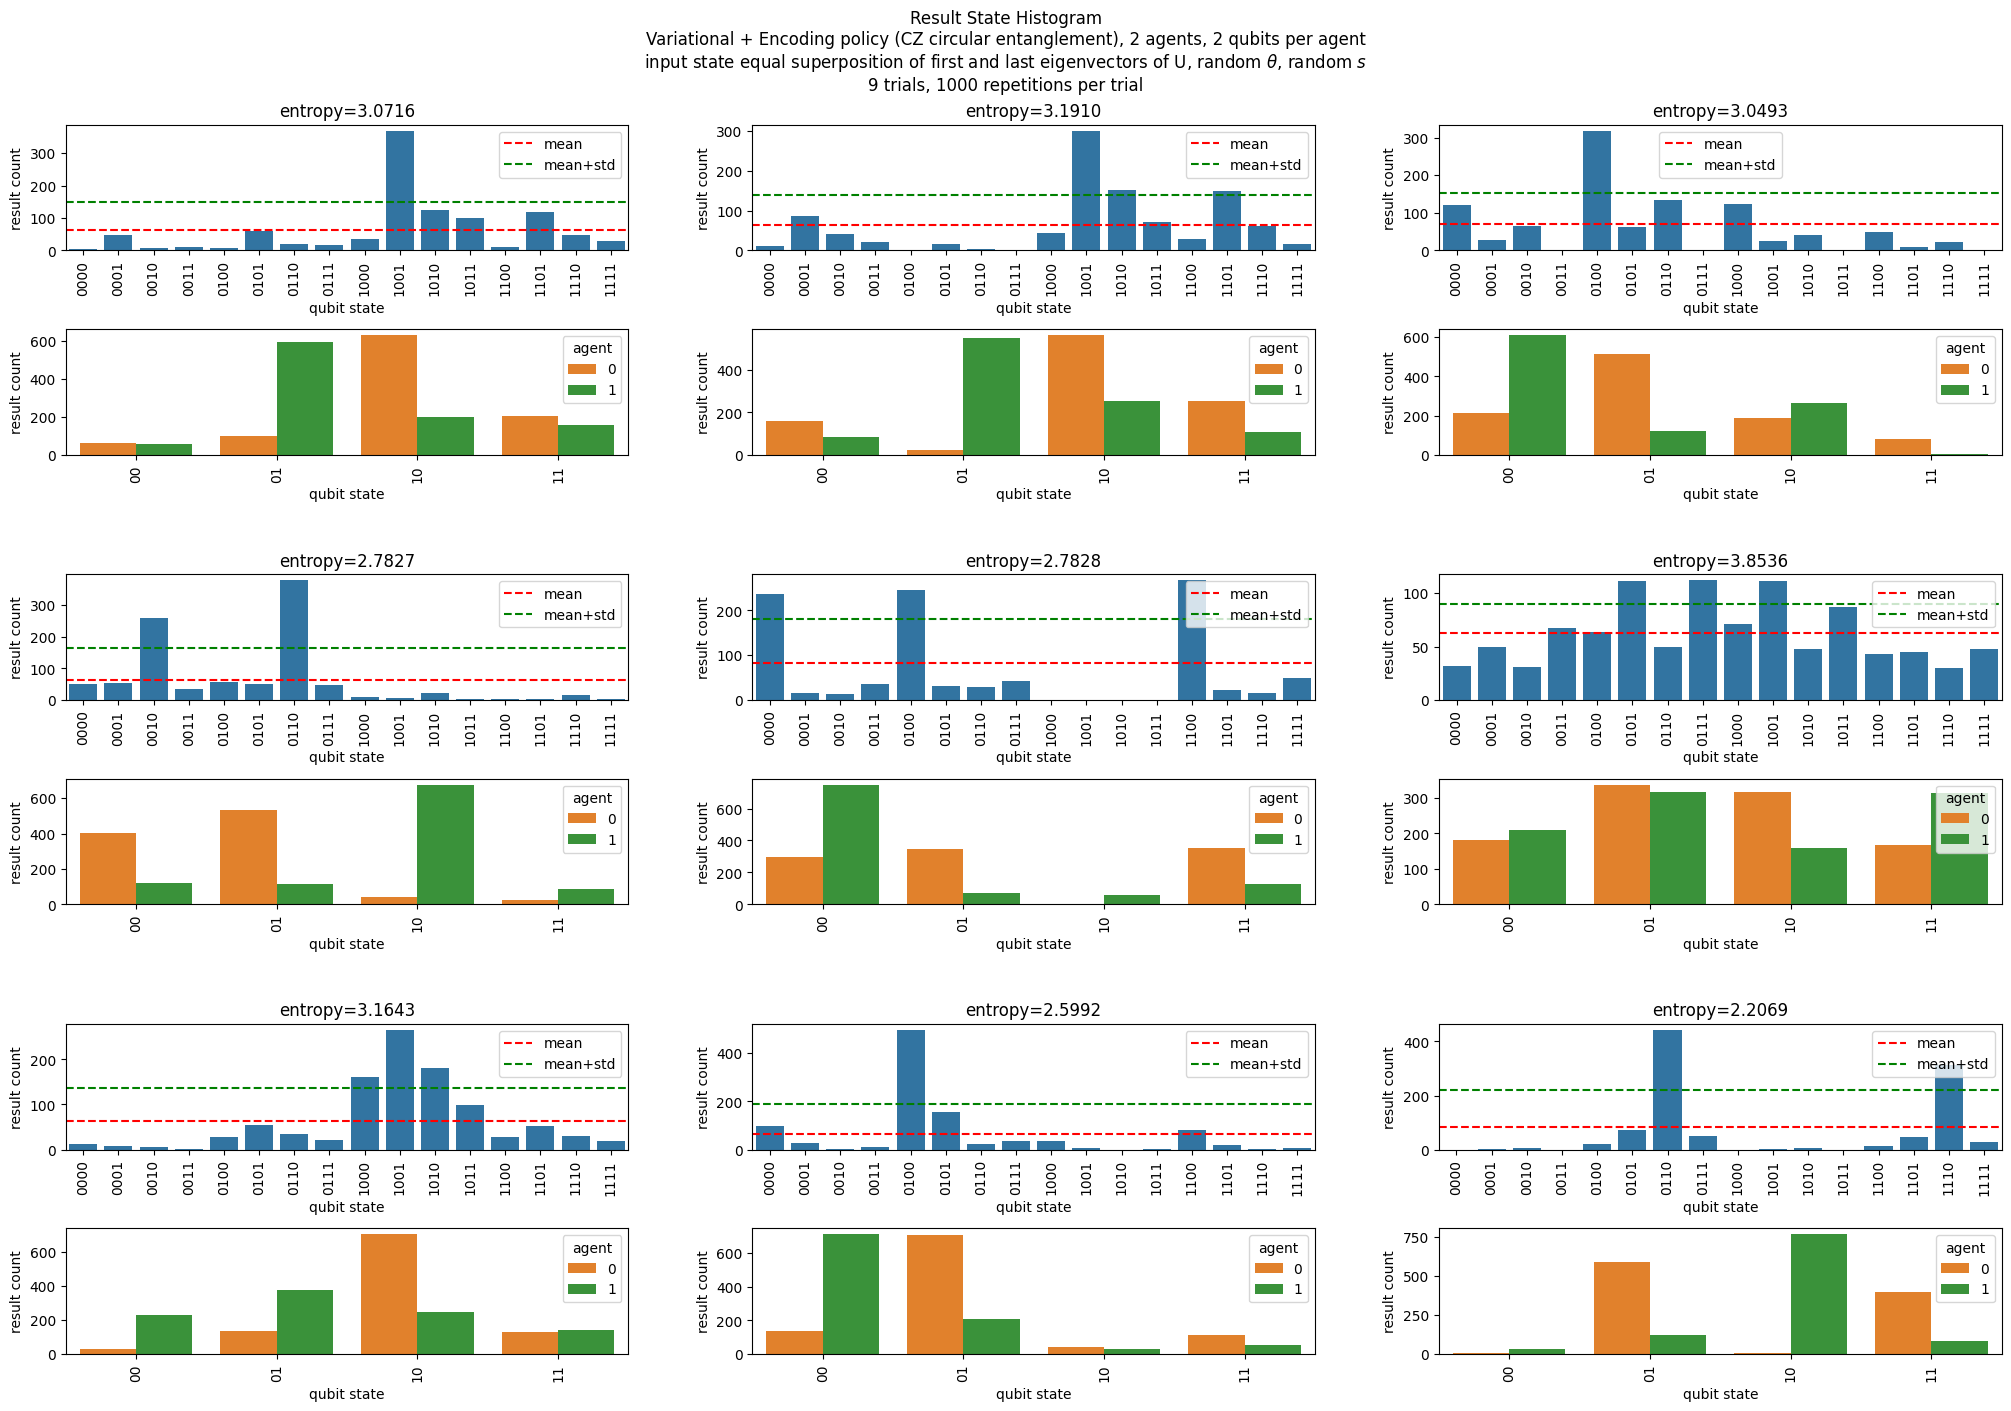

In [23]:
# Create the desired starting state.
# In this case, an equal superposition of the first and last eigenvector.
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]
print(f"initial_state_vector={cirq.dirac_notation(initial_state_vector)}")

# Define a function that will prepare this state given a list of qubits.
initial_state_prep_fn = lambda qubits: prepare_state_from_state_vector(qubits, target_state=initial_state_vector)

with testing_context():
    # Run experiments using the initial state.
    test_runner(
        d=d_qubits, n=n_agents,
        repetitions=repetitions,
        figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
        subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
        figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state equal superposition of first and last eigenvectors of U, random $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
        policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
        symbol_resolver_fn=ParamResolverRandomThetaRandomS(),
        initial_state_prep_fn=initial_state_prep_fn,
    )

##### Equal superposition of all eigenvectors

initial_state_vector=(0.09-0.13j)|0000⟩ + (-0.25-0.07j)|0001⟩ + (0.06+0.09j)|0010⟩ + (0.22+0.08j)|0011⟩ + (0.08+0.36j)|0100⟩ + (-0.13-0.11j)|0101⟩ + (-0.01+0.03j)|0110⟩ + (0.04-0.2j)|0111⟩ + (0.44-0.06j)|1000⟩ + (0.28-0.24j)|1001⟩ + (0.08+0.28j)|1010⟩ + (0.04-0.21j)|1011⟩ + (0.06+0.03j)|1100⟩ + (-0.24-0.1j)|1101⟩ + (-0.22-0.02j)|1110⟩ + (-0.17+0.05j)|1111⟩


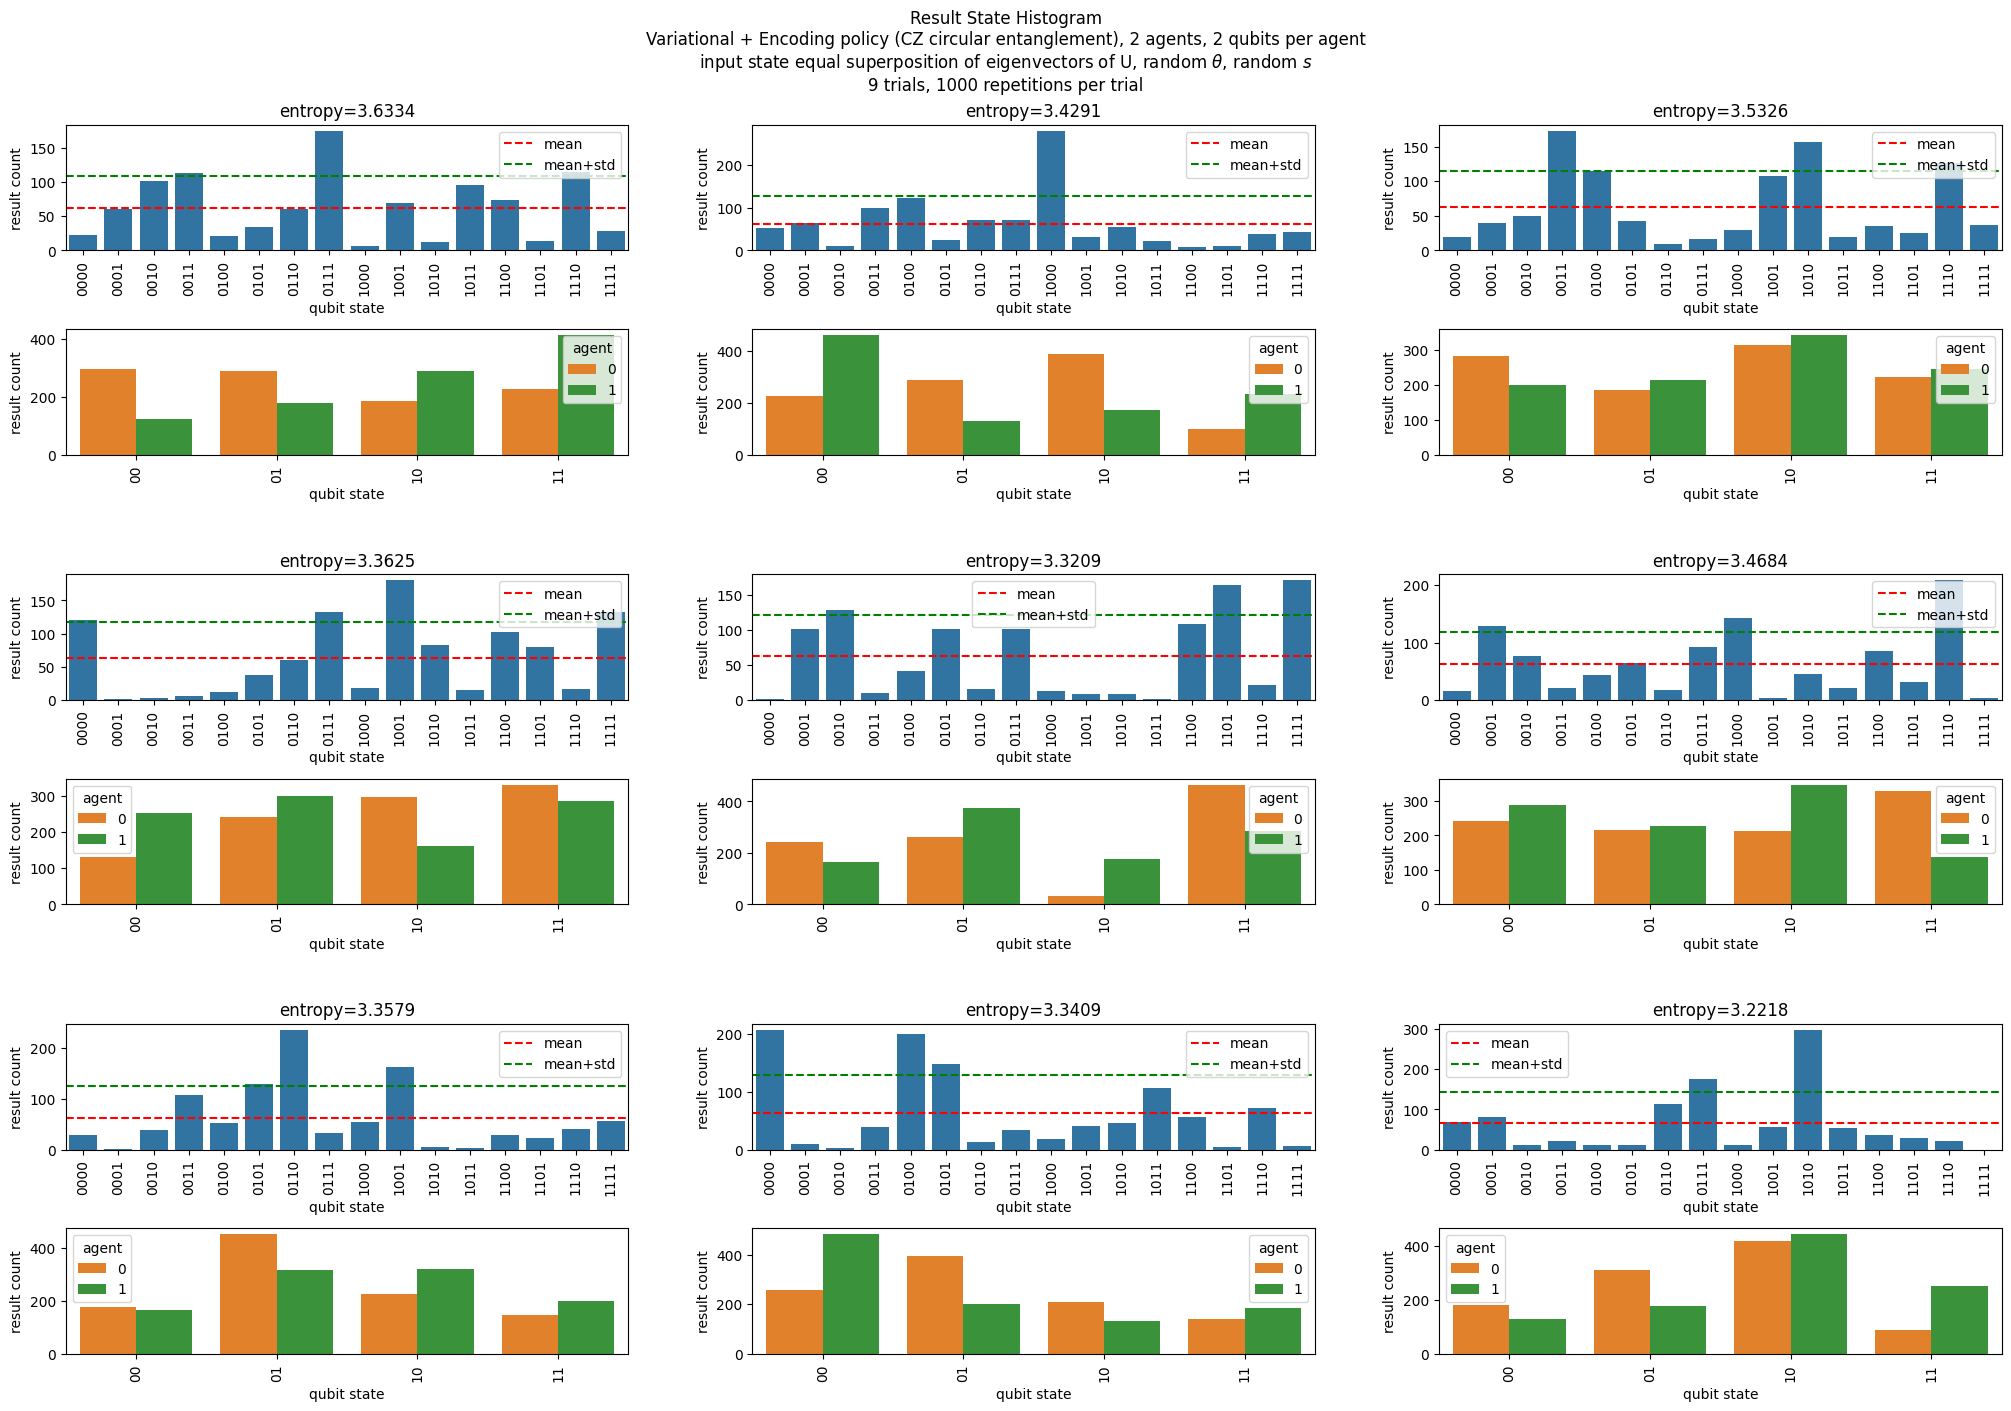

In [24]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.
print(f"initial_state_vector={cirq.dirac_notation(initial_state_vector)}")

# Define a function that will prepare this state given a list of qubits.
initial_state_prep_fn = lambda qubits: prepare_state_from_state_vector(qubits, target_state=initial_state_vector)

with testing_context():
    # Run experiments using the initial state.
    test_runner(
        d=d_qubits, n=n_agents,
        repetitions=repetitions,
        figure_kwargs=dict(layout='constrained', figsize=(20, 14)),
        subfigure_kwargs=dict(nrows=nrows, ncols=ncols, wspace=0.09, hspace=0.09),
        figure_title=f'Result State Histogram\nVariational + Encoding policy (CZ circular entanglement), {n_agents} agents, {d_qubits} qubits per agent\ninput state equal superposition of eigenvectors of U, random $\\theta$, random $s$\n{nrows * ncols} trials, {repetitions} repetitions per trial',
        policy_fn=lambda qubits, aidx: parameterized_variational_encoding_policy_circuit(qubits, n_layers=n_layers, symbol_superscript_index=aidx),
        symbol_resolver_fn=ParamResolverRandomThetaRandomS(),
        initial_state_prep_fn=initial_state_prep_fn,
    )